# Overview 
In this assignment we will implement and test K-means algorithm for clustering and principal component analysis (PCA) for dimensionality reduction.  

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, please ask. 

Before you start, make sure you have installed all those packages in your local Jupyter instance

## Read *all* cells carefully and answer all parts (both text and missing code)

You will complete all the code marked `TODO` and answer descriptive/derivation questions 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import sys

## Question 1. K-Means Clustering

In this exercise we will first implement K-means algorithm for clustering. Then we will perform color-based segmentation using K-means.



## K-means clustering implementation [10 pts]

Let us first implement K-means algorithm that accepts target number of clusters (K) and data vectors $\mathbf{x}_1,\ldots, \mathbf{x}_N$, each of length $d$. At this point, we will implement the K-means algorithm for general $d$; later we will test and visualize the results for $d=2,3$. 
			
A general K-means algorithm can be described as follows. 
Suppose we are given training examples $\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N$, where each $\mathbf{x}_i \in \mathbb{R}^d$. We want to group the $N$ data samples into K clusters.  
* Initialize cluster centers $\mu_1,\ldots, \mu_K \in \mathbb{R}^d$ at random
* Repeat until convergence 
  * For every data point $\mathbf{x}_i$, update its label as 
  \begin{equation*}
  z_i = \text{argmin}_j \|\mathbf{x}_i - \mu_j\|_2^2. 
  \end{equation*}
  
  * For each cluster $j$, update its center $\mu_j$ as mean of all points assigned to cluster $j$: 
  $$ \mu_j = \dfrac{\sum_{i=1}^N \delta\{z_i = j\} \mathbf{x}_i}{\sum_{i=1}^N \delta \{z_i = j\}}.$$  
  $\delta\{z_i = j\}$ denotes an indicator function that is equal to 1 if $z_i = j$ and zero otherwise. $\sum_{i=1}^N\delta\{z_i = j\}$ indicates the number of points in $i$th cluster. 

We can define sum of squared errors (SSE) as 
$ \text{SSE}  = \sum_j \sum_i \delta\{z_i = j\} \|\mathbf{x}_i - \mu_j\|_2^2$`


Implement the K-means clustering algorithm as a function with the following specifications:

```python
def kmeans_clustering(data, K, max_iter = 100, tol = pow(10,-3)):
```
where 
1. 'data' is the $N \times d$ matrix that contains all data points ($N$ is the number of data points and $d$ is the number of features, each row of the matrix is a data point), 
2. 'K' is the number of clusters, 
3. 'max_iter' is the maxium number of iterations, and 
4. 'tol' is the tolerance for the change of the sum of squares of errors that determines convergence.

Your function should return the following variables: 
1. 'labels': this is an $N\times 1$ vector (where $N$ is the number of data points) where the $i$-th position of that vector contains the cluster number that the $i$-th data point is assigned to, 
2. 'centroids': this is a $K\times d$ matrix, each row of which contains the centroid for every cluster, 
3.  'SSE_history': this is a vector that contains all the sum of squares of errors per iteration of the algorithm, 
4. 'iters': this is the number of iterations that the algorithm ran.

Here we are going to implement the simplest version of K-means, where the initial centroids are chosen entirely at random among all the data points.

Your algorithm should converge if 1) the maximum number of iterations is reached, or 2) if the SSE between two consecutive iterations does not change a lot. 

In order to check for the latter condition, you may use the following piece of code:
```python
if np.absolute(SSE_history[it] - SSE_history[it-1])/SSE_history[it-1] <= tol
```



In [ ]:
# Used for l2 norms
def lpDistance(x1, x2, p):
	distance = 0.0
	for i in range(len(x1)):
		distance += abs((x1[i] - x2[i])**p)
	
	return distance ** (1/p)

In [ ]:
# K-means clustering
def kmeans_clustering(data, K, max_iter = 100, tol = pow(10, -3)): 
  # Inputs
  #   data - N x d array
  #   K - number of clusters
  #   max_iter - maximum iterations for K-means
  #   tol - stopping parameter that checks relative change in sum of squared errors
  # 
  # Outputs: 
  #   labels - cluster assignment label for each data sample (N values)
  #   centroid - centroids of each cluster (K vectors)
  #   SSE_history - table of SSE record at every iteration
  #   iter - total number of iterations at stopping/convergence

  # Numpy Arrays & Variables
  N = len(data)
  iter = 0
  centroids = np.zeros(data.shape)
  labels = np.zeros(N)
  distances = np.zeros(K)
  sums = np.zeros(data.shape)
  SSE_history = np.arange(max_iter + 1)

  # Avoid divide by 0
  SSE_history[0] = 2
  SSE_history[1] = 1

  # K initial clusters chosen at random
  for j in range(K):
    centroids[j] = data[random.randint(0, N - 1)]

  #while (iter < max_iter):
  while ((iter < max_iter) and (np.absolute(SSE_history[iter] - SSE_history[iter - 1])/SSE_history[iter - 1] > tol)):
    iter += 1
  
    # Label each data point
    for i in range(N): # For each data point
      for j in range(K): # For each centroid
        distances[j] = lpDistance(data[i], centroids[j], 2)

      # Fixes bug where random initialization sometimes makes 2 distances equal
      if(np.shape(np.where(distances == np.amin(distances))) != (1, 1)):
        temp = np.where(distances == np.amin(distances))[0]
        labels[i] = temp[0]
      else:
        labels[i] = np.where(distances == np.amin(distances))[0] # Label is centroid w/ min distance (0 to K - 1)

    # Adjust centroids
    for j in range(K): # For each centroid
      numPointsInLabel = 0
      sums[j] = 0

      for i in range(N): # For each data point
        if (labels[i] == j): # If data point is in cluster
          sums[j] += data[i]
          numPointsInLabel += 1

      if(numPointsInLabel == 0): # Cluster has no data
        centroids[j, :] = sys.maxsize
      else: # Cluster has data
        centroids[j] = sums[j]/numPointsInLabel    

    # Calculate sum of squared errors (SSE)
    for j in range(K): # For each centroid
      if(centroids[j, 0] != sys.maxsize): # Exclude centroids with no data
        for i in range(N): # For each data point
          if (labels[i] == j):
            SSE_history[iter] += lpDistance(data[i], centroids[j], 2) 

  return labels, centroids, SSE_history, iter

### Test K-means on simulated data with different values of K

Let us create synthetic data with `num_clusters` clusters in 2-dimensional space and apply K-means clustering. 

You should try with different values of `num_clusters` and `K'. 



(-17.726861844127246,
 19.12303626355257,
 -26.63326719218026,
 20.673823937197316)

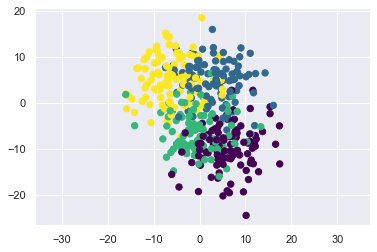

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.datasets import make_blobs

num_clusters = 4
X, y_true = make_blobs(n_samples = 400, centers = num_clusters, cluster_std = 5, random_state = 10)

plt.scatter(X[:, 0], X[:, 1], c = y_true, s = 40, cmap = 'viridis')
ax = plt.gca()
ax.axis('equal')

Let us now run K-means using different values of K.

Try `K = [num_clusters-1, num_clusters, num_clusters+1]`

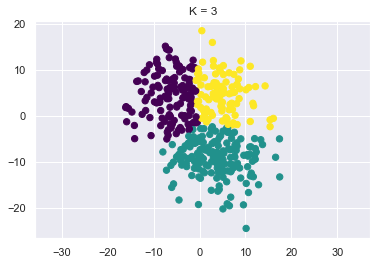

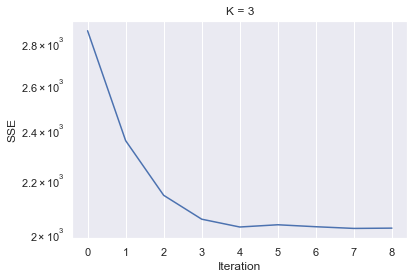

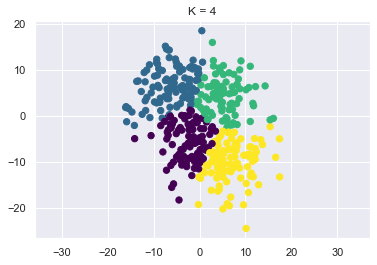

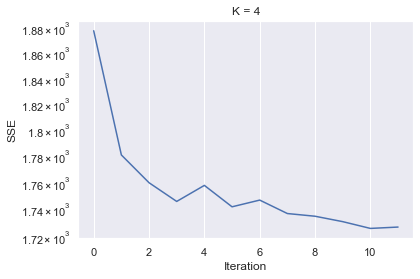

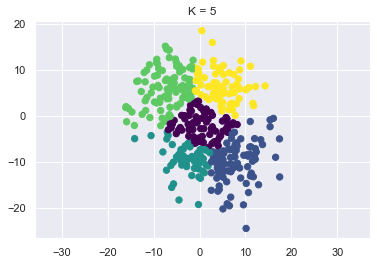

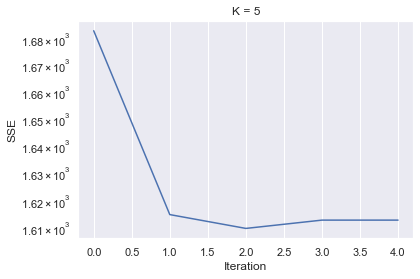

In [ ]:
# Run K-means for different values of K. 
for K, i in zip([num_clusters - 1, num_clusters, num_clusters + 1], range(3)):
  plt.figure(i)
  labels, centroids, SSE_history, iters = kmeans_clustering(X, K)
  plt.scatter(X[:, 0], X[:, 1], c = labels, s = 40, cmap = 'viridis')
  ax = plt.gca()
  ax.axis('equal')
  plt.title('K = ' + str(K))

  # plot SSE over different iterations 
  plt.figure(i + 3)
  xaxis = np.arange(iters)
  plt.semilogy(xaxis, SSE_history[1:iters + 1])
  plt.xlabel('Iteration')
  plt.ylabel('SSE')
  plt.title('K = ' + str(K))


### Answer the following questions

- Q: What happens to SSE at every iteration of K-means algorithm (did it increase/decrease)? [1 pt]

> A: SSE generally decreases at every iteration but will sometimes increase at certain iterations based on the random initialization of the clusters


- Q: How does the SSE change as you increase K ? [1 pt]

> A: SSE decreases as I increase K

- Q: What happens if you increase the `cluster_std` of blobs above to `cluster_std=5` ? [2 pts] 
```
X, y_true = make_blobs(n_samples=400,centers=num_clusters,cluster_std=3,random_state=10)
```

> A: The initial blobs become more clustered together and overall SSE increases for all K's

### Color segmentation/quantization

Now we will use K-means to perform segmentation/quantization on a color image. 

Each pixel in a given image will be a feature vector containing 3 color components (RGB). We will first group all colors into K clusters, which will provide us a color palatte. Then we will replace the color in every pixel with one of the colors in the color palatte (that is the centroid of the cluster in which RGB value of a pixel falls). 

We will use K-means script from previous step to segment your image into K clusters. To create a "quantized" output image, replace every pixel in your image with the center of the cluster assigned to it. Report your results for K= $\{2,4, 8, 16, 32, 64\}$ clusters.  

__You will need a colorful selfie__

Take a _selfie_ of yourself with a background that has different colors from your skin and clothing. 

Let us say you name the image `selfie.jpg`



In [ ]:
# Upload Image
import cv2

uint8
(1440, 1919, 3)


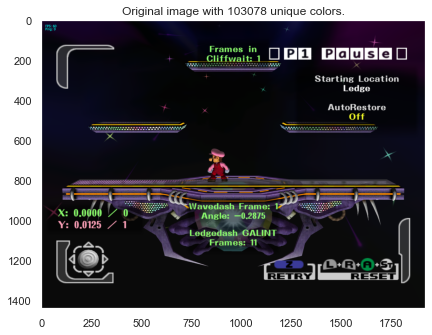

In [ ]:
# load and display an image with Matplotlib
from matplotlib import image

# load image as pixel array
img = cv2.imread('images/Ledgedash.png')

# summarize shape of the pixel array
print(img.dtype)
print(img.shape)

# load the picture 
h, w, c = img.shape
unique_colors = np.unique(np.reshape(img, (h * w, c)), axis = 0)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.grid(False)
plt.title('Original image with {0:d} unique colors.'.format(unique_colors.shape[0]))
plt.imshow(img)
plt.show()

Before performing the clustering, we will process the image data. 

1. You can crop or resize your image to a small size if the image is large. An image close to $100\times 100$ pixels will be sufficient for this experiment. 

2. Convert 8 bit integers to floats by dividing every pixel by 255 so that we can perform floating point operations and plot the arrays as images using plt.imshow that works well on float data in the range [0-1].



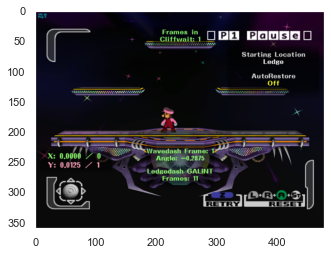

In [ ]:
# Resize image to speed things up
from PIL import Image 

# use resize function if needed 
img = Image.open('images/Ledgedash.png')
img_size = img.size

# modify the size 
new_size = np.asarray(img_size)/4
img = img.resize(new_size.astype(int))
img = np.asarray(img)
plt.imshow(img)
plt.grid(False)

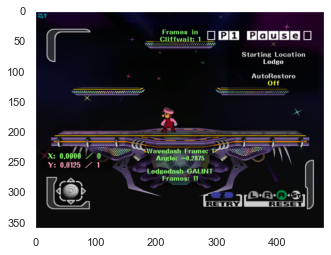

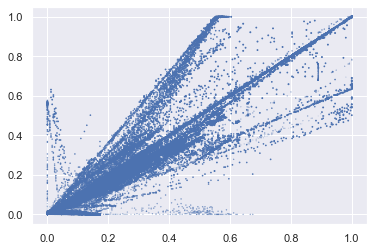

In [ ]:
# Preprocessing the data for clustering
# convert to float64 in range [0, 1]
if np.max(img) > 1:
  img = np.array(img, dtype=np.float64) / 255
plt.imshow(img)
plt.grid(False)

# Load Image and transform to a 2D numpy array.
h, w, c = original_shape = tuple(img.shape)

assert c == 3
data = np.reshape(img, (w * h, c))

plt.figure()
plt.scatter(data[:, 0], data[:, 1], data[:, 2])

Now we will perform two steps. 

1. K-means clustering for different values of K using the `kmeans_clustering` function above. 

2. Replace all the colors in the original image with the centroids of the cluster each of them belong to. This will give us a "segmented/quantized image" for different values of K; let us denote each image as `img_seg`. 

Plot the original image and the `img_seg` for `K = 2, 4, 8, 16, 32, 64.` 

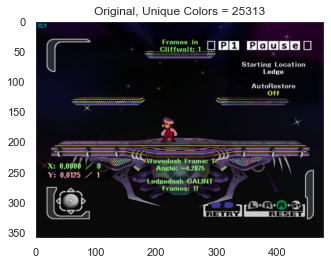

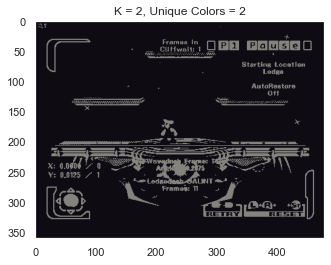

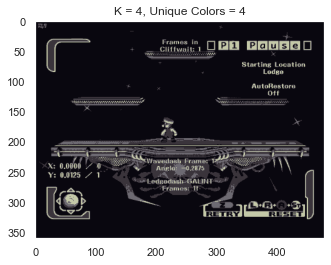

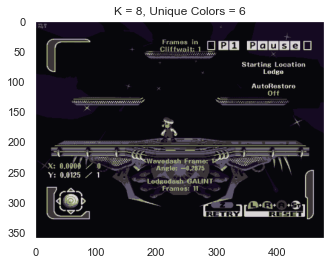

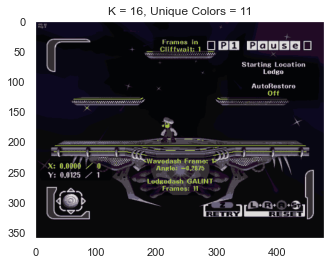

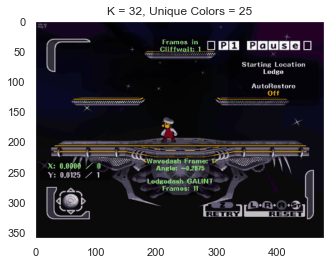

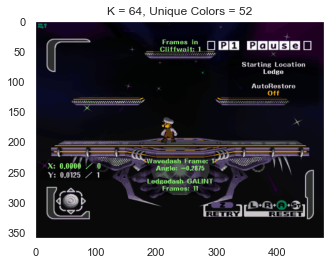

In [ ]:
# For K = 2, 4, 8, 16, 32, 64 
  # Perform K-means clustering for different values of K on RGB pixels; 
  # this will give you K RGB values as centroids of K clusters

  # Create a quantized image based on your cluster assignment
  # Plot original and quantized images 

# Original
uniqueColors = np.unique(np.reshape(img, (h * w, c)), axis = 0)
plt.figure(0)
plt.grid(False)
plt.title("Original, Unique Colors = " + str(uniqueColors.shape[0]))
plt.imshow(img)

# Quantized
for K, i in zip([2, 4, 8, 16, 32, 64], range(6)):
  labels, centroids, SSE_history, iters = kmeans_clustering(data, K, max_iter = 100, tol = pow(10,-3))
  segmentedData = centroids[labels.astype(int)]
  img_seg = segmentedData.reshape((img.shape))
  uniqueColors = np.unique(np.reshape(img_seg, (h * w, c)), axis = 0)
  plt.figure(i + 1)
  plt.grid(False)
  plt.title("K = " + str(K) + ", Unique Colors = " + str(uniqueColors.shape[0]))
  plt.imshow(img_seg)


### Answer the following questions

- Q: How many unique colors you have in the quantized image for K=2?

> A: 2

- Q: How is the quality of "quantized image" affected as you increase K?

> A: The image gets more unique colors and looks closer to the original quality of the image

- Q: What value of K provides you best quality for the "quantized image"?

> A: K = 64